In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [30]:
import pandas as pd
import gzip
import csv
import os
from glob import glob
try:
    import cPickle as pickle
except ImportError:
    import pickle
import seaborn as sn
sn.set_context("poster")

In [12]:
ls ../data/obfuscate/


101/  102/  103/  104/


# Load Functions

In [6]:

class LogReader(object):
    """An object that handles reading from .slog files.

    Passing in a filename, by calling **ReadRecord** you can read on
    row from the .slog file.

    Parameters
    ----------
    filename : string
        The name of the .slog that you wish to read.
    unwrap : boolean
        Whether to unwrap sub-dicts and tuples when reading.
    append_columns : dict
        Additional columns to add to each record.
    """
    def __init__(self, filename, unwrap=False, **append_columns):
        # set the file
        self._file = gzip.open(filename, "rb")

        # save whether we should unwrap when reading
        self._unwrap = unwrap

        # save additional columns to append
        self._append_columns = append_columns

        # set up the unpickler
        self._unpickler = pickle.Unpickler(self._file)

    def read_record(self):
        """Returns a dicitionary with the field names as keys.
        """
        try:
            # get the dict
            rec = self._unpickler.load()

            # unwrap it
            if self._unwrap:
                rec = _unwrap(rec)

            # append additional cols
            rec.update(self._append_columns)

            # return it
            return rec
        except EOFError:
            return None

    def close(self):
        self._file.close()

    def __iter__(self):
        record = self.read_record()
        while record is not None:
            yield record
            record = self.read_record()
        self.close()


def _unwrap(d, prefix=''):
    """Process the items of a dict and unwrap them to the top level based
    on the key names.

    """
    new_item = {}
    for k in d:
        # add prefix
        key = prefix+k

        # see if dict
        if isinstance(d[k], dict):
            new_item.update(_unwrap(d[k], prefix=key+'_'))
            continue

        # see if tuple/list
        if isinstance(d[k], (tuple, list)):
            # turn into indexed dict
            tdict = {}
            for j in range(len(d[k])):
                tdict[str(j)] = d[k][j]
            new_item.update(_unwrap(tdict, prefix=key+'_'))
            continue

        # just add it in
        new_item[key] = d[k]

    return new_item


def _root_to_files(log_filename):
    """Get set of slogs from root."""
    if os.path.exists(log_filename):
        # there is just one
        log_files = [log_filename]
    else:
        # try appending numbers
        log_files = []
        for distinguisher in xrange(256):
            filename = "%s_%d.slog" % (log_filename,
                                       distinguisher)
            if os.path.exists(filename):
                log_files.append(filename)
            else:
                break
    return log_files


def log2dl(log_filename, unwrap=True, **append_columns):
    """Convert slog files to list of dicts (a dict-list).

    Parameters
    ----------
    log_filename : string
        Either a full filename with the slog extension or base
        name with everything up to the numerical index of a log,
        such as 'log_study', which will use the same algorithm
        that saved the files each time the experiment was run in
        in order to loop and read them all in.
    unwrap : boolean
        Whether to unwrap logged lists and dictionaries into a
        single row. e.g., 'log': {'time':10, 'error':.001} would
        turn into two columns: 'log_time' and 'log_error'.
    append_columns : kwargs
        Columns to add the same value to each row. Useful for adding
        a subject id to the data.

    Examples
    --------
    This method is particularly useful for loading data for analysis
    with Pandas. This example will load all logs that begin with
    "log_study" into a Pandas DataFrame, adding in a column for
    subject:

    ..
        import pandas as pd
        df = pd.DataFrame(log2dl('log_study', subject='exp001'))

    """
    # determine set of slogs
    log_files = _root_to_files(log_filename)
    if len(log_files) == 0:
        raise IOError("No matching slog files found.")

    # loop over slogs pulling out dicts
    dl = []
    for i, slog in enumerate(log_files):
        append_columns.update({'log_num': i})
        dl.extend([r for r in
                   LogReader(slog,
                             unwrap=unwrap,
                             **append_columns)])
    return dl


# Load Data

In [87]:
data_dir = os.path.join("..", "data", "obfuscate")
subj_paths = glob(os.path.join(data_dir, "*"))
data = []
dropped_subj = []
num_prime = 2
num_rec = 2

for sp in subj_paths:
    
    print("Subject: %s" % (sp[sp.rfind("/") + 1:]))
    if not (sp[sp.rfind("/") + 1:] in dropped_subj):
        for dlp in glob(os.path.join(sp, "*", "log_TEST*.slog")):
            temp = pd.DataFrame(log2dl(dlp, 
                                       subj=sp[sp.rfind("/") + 1:]))
            # get rid of instructions trials
            temp = temp[temp.cond != "INST"]

            # get rid of prime and rec
            temp = temp.iloc[num_prime: -num_rec]
            data.append(temp)
data = pd.concat(data)

Subject: 101
Subject: 104
Subject: 102
Subject: 103


# Clean Data

In [88]:
data['correct'] = (data.corr_resp == data.oldnew_pressed)
data['confidence'] = np.zeros_like(data.shape[0])

conf_dict = {'S': "0%", 'D': "20%", 'F': "40%", 
             'J': "60%", 'K': "80%", 'L': "100%"}
for l in conf_dict.keys():
    data.loc[data.conf_pressed == l, "confidence"] = conf_dict[l]

# View Data

In [89]:
data.head()

,cond,conf_appear_time_error,conf_appear_time_time,conf_base_time,conf_pressed,conf_rt,corr_resp,encode_cond,log_num,log_time,oldnew_base_time,oldnew_pressed,oldnew_rt,stim,stim_appear_time_error,stim_appear_time_time,subj,correct,confidence
2,OLD,0.0,389.963671,389.963671,K,1.260768,F,OBS,0,391.224439,386.159077,F,3.784523,.\assets\stim\recog\rec_28.jpg,0.0,386.159077,104,True,80%
3,NEW,0.0,394.205803,394.205803,F,0.954655,J,OBS,0,395.160458,391.635769,J,2.515792,.\assets\stim\recog\rec_20.jpg,0.0,391.635769,104,True,40%
4,OLD,0.0,397.867796,397.867796,L,2.508060,F,OBS,0,400.375856,395.570029,F,2.214513,.\assets\stim\recog\rec_56.jpg,0.0,395.570029,104,True,100%
5,NEW,0.0,408.427583,408.427583,J,2.188878,J,OBS,0,410.616461,400.786385,F,7.621861,.\assets\stim\recog\rec_04.jpg,0.0,400.786385,104,False,60%
6,NEW,0.0,416.077472,416.077472,J,1.449425,J,OBS,0,417.526896,411.021461,J,5.018743,.\assets\stim\recog\rec_12.jpg,0.0,411.021461,104,True,60%


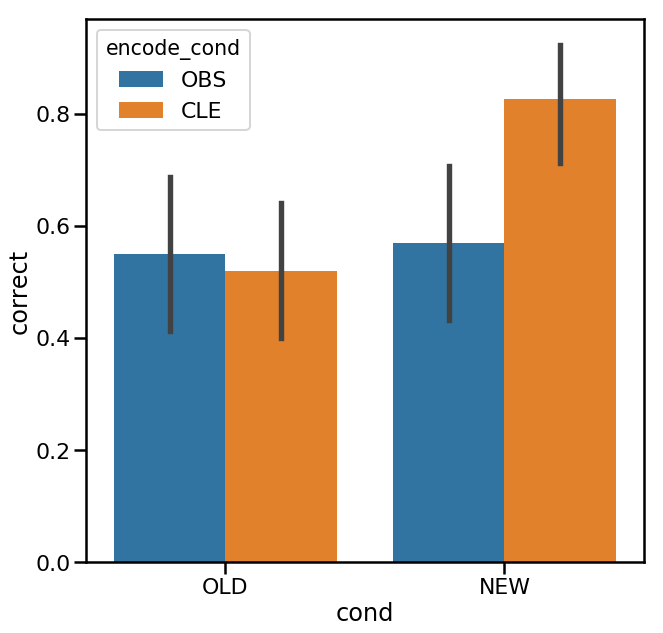

In [90]:
fig = figure(figsize=(10,10))
sn.barplot(data=data, x='cond', y="correct", hue="encode_cond")

Text(0,0.5,'Percent Correct')

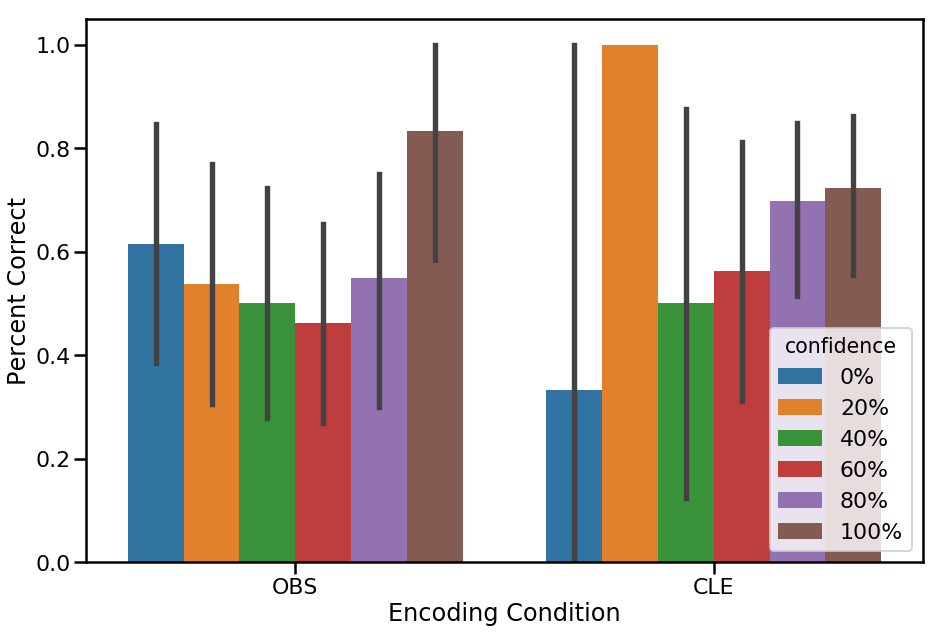

In [92]:
fig = figure(figsize=(15,10))
ax = sn.barplot(data=data, x="encode_cond", y="correct",
                hue="confidence", hue_order=["0%", "20%", "40%", 
                                             "60%", "80%", "100%",])
ax.set_xlabel("Encoding Condition")
ax.set_ylabel("Percent Correct")